# NYC Taxi Duration

In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualization library

#warnings.filterwarnings('ignore')
%matplotlib inline

## Data Loading

In [25]:
TRAIN_PATH = os.path.join("..", "input", "train.csv")
TEST_PATH = os.path.join("..", "input", "test.csv")

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

In [26]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


## Data Exploration

In [28]:
train.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [29]:
train.trip_duration.min()

1

In [30]:
train.trip_duration.max()

3526282

 Pour pas fausser les résultats on décide d'enlever les trajets ou il y a un temps minimum d'une seconde et un maximum de 40jours.
Je vais estimer qu'un temps de trajet doit être compris entre 1-5min et plusieurs heures

## Data Preprocessing

Gestion des outliers

In [31]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


Il y a des valeurs aberrantes pour les trip_duration en min et max. 

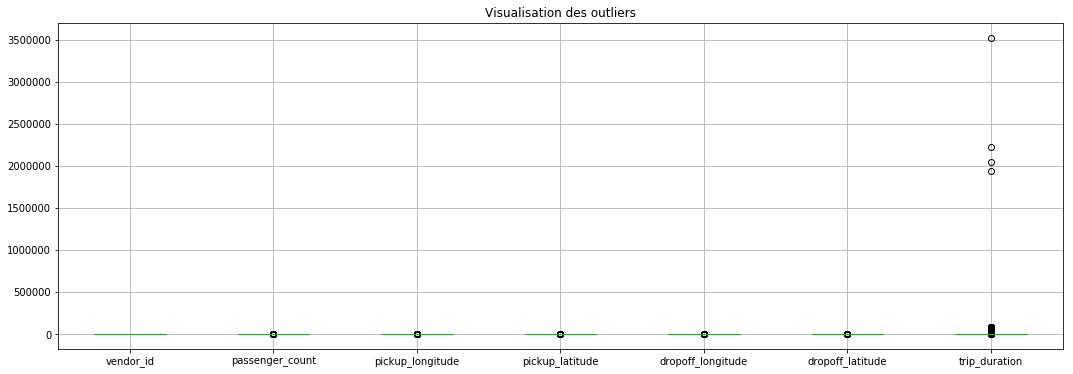

In [32]:
plt.subplots(figsize=(18,6))
plt.title("Visualisation des outliers")
train.boxplot();

## Features engineering

In [33]:
col_diff = list(set(train.columns).difference(set(test.columns)))
col_diff

['dropoff_datetime', 'trip_duration']

In [34]:
#Calcule de la distance entre drop et pickup
train['dist'] = np.sqrt((train['pickup_latitude']-train['dropoff_latitude'])**2
                        + (train['pickup_longitude']-train['dropoff_longitude'])**2)
test['dist'] = np.sqrt((test['pickup_latitude']-test['dropoff_latitude'])**2
                        + (test['pickup_longitude']-test['dropoff_longitude'])**2)

In [35]:
#il n'est pas nécessaire d'avoir 0 passager, nous allons les enlever
train = train[train['passenger_count']>= 1]

In [36]:
# La durée du voyage est comprise entre 1 sec. et 3526282 sec.
# Nous laisserons tomber les valeurs inférieures à 1 min 30 (90sec) et supérieures à 166 min (10 000 sec).
train = train[train['trip_duration']>= 1.5 ]
train = train[train['trip_duration']<= 10000 ]

In [37]:
# Nous allons laisser tomber la longitude et la latitude (On drop ce qui ressemble à des valeurs aberrantes)
train = train.loc[train['pickup_longitude']> -90]
train = train.loc[train['pickup_latitude']< 47.5]

train = train.loc[train['dropoff_longitude']> -90]
train = train.loc[train['dropoff_latitude']> 34]


In [38]:
#convertir le string en datetime pour avoir que l'heure 
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')

In [39]:
#ajout dans une nouvelle colonne
train['hour'] = train.loc[:,'pickup_datetime'].dt.hour;
test['hour'] = test.loc[:,'pickup_datetime'].dt.hour;

In [40]:
#Ajout dans une nouvelle colonne à train 
X_train = train[["passenger_count","vendor_id", "pickup_longitude", "pickup_latitude", "dropoff_longitude","dropoff_latitude", "dist", "hour" ]]


In [51]:
y_train = train["trip_duration"]  # This is our target
X_train = train[["passenger_count","vendor_id", "pickup_longitude", "pickup_latitude", "dropoff_longitude","dropoff_latitude", "dist","hour" ]]

## Selection du modèle

In [42]:
# importer la lib pour cross valider le model
from sklearn.model_selection import cross_val_score

# importer la lib pour la regression de Random Forest
from sklearn.ensemble import RandomForestRegressor

# importer la lib pour la regression de Random Forest
from sklearn.linear_model import SGDRegressor

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import ShuffleSplit

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=42)


In [44]:
sgd = SGDRegressor()
sgd.fit(X_train, y_train)

d:\dev_tools\python3.7\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

## 6. Entrainement du ou des modèle(s) & Predictions¶


In [52]:
b2o = RandomForestRegressor(n_estimators=19, min_samples_split=2, min_samples_leaf=4, max_features='auto', max_depth=80, bootstrap=True)
b2o.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=19, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [46]:
cv = ShuffleSplit(n_splits=4, test_size=0.8, random_state=42)
cv_scores = cross_val_score(b2o, X_train, y_train, cv=cv, scoring= 'neg_mean_squared_log_error')

In [47]:
cv_scores

array([-0.2010094 , -0.1991451 , -0.20129191, -0.20199777])

In [48]:
for i in range(len(cv_scores)):
    cv_scores[i] = np.sqrt(abs(cv_scores[i]))
print(np.mean(cv_scores))

0.44817369548047825


## Prediction

In [49]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,dist,hour
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,0.024735,23
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,0.024979,23
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,0.013861,23
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,0.051363,23
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,0.010343,23


In [53]:
X_fit = test[["vendor_id", "passenger_count","pickup_longitude", "pickup_latitude","dropoff_longitude","dropoff_latitude","dist","hour"]]
prediction = b2o.predict(X_fit)
prediction

array([ 799.21363841,  613.9032006 ,  435.77265279, ..., 1680.05933014,
       2307.20354514, 1111.99637395])

In [54]:
my_submission = pd.DataFrame({'id': test.id, 'trip_duration': prediction})
my_submission.head()

,id,trip_duration
0,id3004672,799.213638
1,id3505355,613.903201
2,id1217141,435.772653
3,id2150126,907.782494
4,id1598245,345.568805


In [55]:
my_submission.to_csv('submission.csv', index=False)